**Welcome to the second programming assignment for CS 443 RL!**

This assignment will have you implementing tabular model-based methods (value iteration, policy iteration, policy evaluation).

In [1]:
import gym
import numpy as np

We will be playing on the
Taxi environment. The environment is loaded as follows:

In [2]:
taxi_env = gym.make('Taxi-v3')
starting_state = taxi_env.reset() #must reset the environment before interacting with it

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The Taxi domain was introduced in the paper "The MAXQ Method for Hierarchical Reinforcement Learning" by Thomas G. Dietterich (https://pdfs.semanticscholar.org/fdc7/c1e10d935e4b648a32938f13368906864ab3.pdf) in ICML 1998.

The version that we will be playing is slightly simpler than the version considered in that paper. Here is a description from the open source code for gym:

> Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

> Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi

    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)

In order to apply the model-based method in the episodic setting, we add a terminal state (the taxi drops off the passenger at the destination) in the MDP. So we end up with 501 states in total. We provide you with an MDP class for modelling the environment. You can directly use it for all the following questions.

In [3]:
class MDP:
  def __init__(self,env):
    self.num_states = env.observation_space.n + 1
    self.num_actions = env.action_space.n
    self.starting_state = starting_state
    self.action_to_plot = 1

    self.R = np.zeros([self.num_states, self.num_actions])
    self.T = np.zeros([self.num_states, self.num_actions, self.num_states])
    self.gamma = 0.99

    for state in range(self.num_states - 1):
      for action in range(self.num_actions):
          for transition in env.env.P[state][action]:
              probability, next_state, reward, done = transition
              self.R[state, action] = reward
              self.T[state, action, next_state] = probability

    for action in range(self.num_actions):
      self.T[-1, action, -1] = 1

    for state in range(self.num_states - 1):
      state_decode = list(env.env.decode(state))
      des_x = taxi_env.env.locs[state_decode[3]][0]
      des_y = taxi_env.env.locs[state_decode[3]][1]
      if (state_decode[2] == 4) and (state_decode[0] == des_x) and (state_decode[1] == des_y):
        self.T[state, 5] = 0
        self.T[state, 5, -1] = 1

  def reset(self):
    env.reset()

The MDP for Taxi is created as follows:

In [4]:
obs = taxi_env.reset()
taxi_mdp = MDP(taxi_env)
#attributes of the MDP:
print(taxi_mdp.num_states) #number of states
print(taxi_mdp.num_actions) #number of actions
print(taxi_mdp.gamma) #gamma
print(taxi_mdp.R.shape) #reward matrix (dimension num_states X num_actions)
print(taxi_mdp.T.shape) #transition matrix (dimension num_states x num_actions X num_states)

501
6
0.99
(501, 6)
(501, 6, 501)


**Q1: Implement the Value Iteration algorithm and solve for $Q^\star$**.

Write a method called `value_iter(mdp)` which takes an MDP as argument and returns the optimal Q-value function ($Q^\star$) as an `np.array` with $501 \times 6$ elements (the number of states $\times$ the number of actions).

Do this by implementing the Value Iteration algorithm seen in class, a.k.a. by repeatedly applying the Bellman operator $\mathcal{T}$. Run your code on the taxi environment and output the optimal Q-value function. As a stopping criterion, you can check if $\lVert Q_n - Q_{n+1}\rVert_\infty < 10^{-4}$.

Plot a 'learning curve' which consists of the optimal Q-value function for the `(starting state, action_to_plot)` pair at each iteration of training. More specifically, your plot should have the iteration number on the $x$-axis and $Q($starting\_state, action\_to\_plot$)$ on the $y$-axis. In `value_iter` function, you can also return other variables that are useful for your plot (e.g. training values) as long as you return the final `Q_fn`.

In the code above, starting_state is defined by `starting_state = taxi_env.reset()`, and `action_to_plot` is set to $1$. In your implementation, you only need to use those variables defined in the MDP class (i.e. `mdp.starting_state`, `mdp.action_to_plot`).

You should expect that the Q-value function of any (state, action) pair does not exceed $20$ no matter how you choose $\gamma$ (we provide `mdp.gamma=0.99`, but you can also try other values).

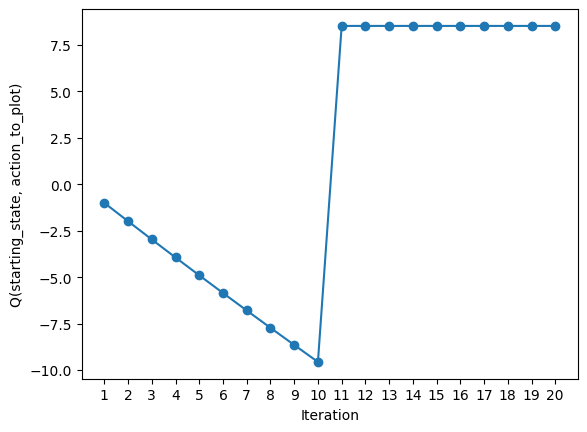

In [5]:
def value_iter(mdp):
    Q_fn = np.zeros([mdp.num_states, mdp.num_actions])
    #YOUR CODE HERE....
    q_vals = []

    Q_old = Q_fn.copy()
    Q_fn = mdp.R + mdp.gamma * np.sum(mdp.T * np.array([[np.max(Q_fn, axis=1)]]), axis=2)
    q_vals.append(Q_fn[mdp.starting_state, mdp.action_to_plot])
    while np.max(abs(Q_fn-Q_old)) >= 1e-4:
        Q_old = Q_fn.copy()
        Q_fn = mdp.R + mdp.gamma * np.sum(mdp.T * np.array([[np.max(Q_fn, axis=1)]]), axis=2)
        q_vals.append(Q_fn[mdp.starting_state, mdp.action_to_plot])

    return Q_fn, q_vals

#might be useful for plotting
import matplotlib.pyplot as mpl
qfn, qvals = value_iter(taxi_mdp)
mpl.plot(range(1, len(qvals)+1), qvals, marker='o')
mpl.xticks(np.arange(1, len(qvals)+1, step=1))
mpl.xlabel('Iteration')
mpl.ylabel('Q(starting_state, action_to_plot)')
mpl.show()

**Q2: Implement the Policy Evaluation algorithm and solve for the Q-value function $Q^\pi$ of a given policy $\pi$.**

Write a method called `policy_eval(mdp, policy)` which takes an MDP and a policy and then outputs the Q-value function $Q^\pi$ (for the input policy in the input MDP) as an `np.array` with $501 \times 6$ elements.

Do this by implementing the Policy Evaluation algorithm seen in class, a.k.a. by repeatedly applying the Bellman operator $\mathcal{T}^\pi$. You should not assume the policy is deterministic. The format of the policy $\pi(a|s)$ is a `(num_states) x (num_actions)` array (i.e. $501 \times 6$). Every row of the policy matrix should be a probability distribution over actions. Run your code on the taxi environment with the policy which acts uniformly at random at every state.

Plot a 'learning curve' which consists of the Q-value function for the `(starting_state, action_to_plot)` pair, i.e. $Q$(starting\_state, action\_to\_plot$)$, at each iteration of training. In `policy_eval` function, you can also return other variables that are helpful for your plot (e.g. training values) as long as you return the final `Q_fn`.

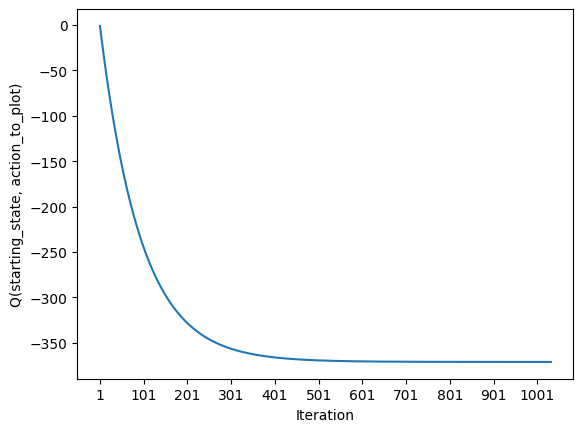

In [6]:
def policy_eval(mdp, policy):
    Q_fn = np.zeros([mdp.num_states, mdp.num_actions])
    # YOUR CODE HERE
    q_vals = []

    Q_old = Q_fn.copy()
    Q_fn = mdp.R + mdp.gamma * np.sum(mdp.T * np.array([[np.sum(Q_fn*policy, axis=1)]]), axis=2)
    q_vals.append(Q_fn[mdp.starting_state, mdp.action_to_plot])

    while np.max(abs(Q_fn-Q_old)) >= 1e-4:
        Q_old = Q_fn.copy()
        Q_fn = mdp.R + mdp.gamma * np.sum(mdp.T * np.array([[np.sum(Q_fn*policy, axis=1)]]), axis=2)
        q_vals.append(Q_fn[mdp.starting_state, mdp.action_to_plot])
    return Q_fn, q_vals


#run your code on the uniform policy
policy_unif = 1./taxi_mdp.num_actions * np.ones([taxi_mdp.num_states,taxi_mdp.num_actions])

qfn, qvals = policy_eval(taxi_mdp, policy_unif)
mpl.plot(range(1, len(qvals)+1), qvals)
mpl.xticks(np.arange(1, len(qvals)+1, step=100))
mpl.xlabel('Iteration')
mpl.ylabel('Q(starting_state, action_to_plot)')
mpl.show()

**Q3: Implement Policy Iteration using your solution from Q2 as a sub-routine, and solve for the optimal policy $\pi^\star$**

Write a method called `policy_iteration(mdp, policy)` which takes an MDP and an *initial* policy, and outputs the optimal policy $\pi^\star$ via successive rounds of policy improvement. The method should return the policy obtained, as a $501 \times 6$ `np.array`.

Run your code on the taxi environment with the policy which acts uniformly at random at every state as a starting policy.

Plot a 'learning curve' which consists of the state-value function for the starting state (i.e. `mdp.starting_state`) for each policy obtained. You can check if/that the optimal value obtained from policy iteration is the same (or close to) the value function obtained from value iteration. You can also return other variables that is useful for your plot (e.g. training values) as long as you return the final policy.

You should expect the results are exactly or almost the same in policy iteration and value iteration. Notice that we get Q-value function in `value_iter` function, and obtain state-value function in `policy_iter` function. If you want to compare the results, you need to have additional step for the conversion.

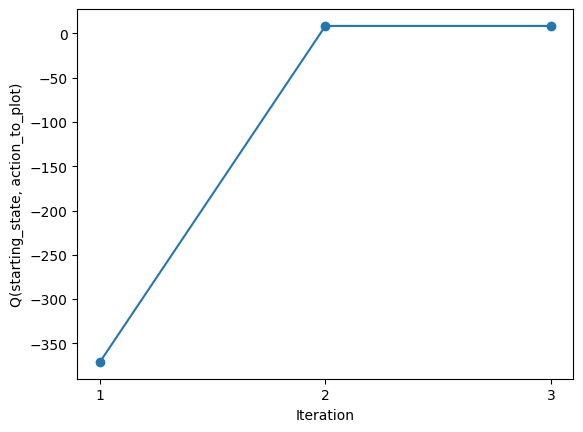

In [7]:
def policy_iter(mdp, policy_init):
    policy = policy_init
    #YOUR CODE HERE
    #Use policy_eval as a sub-routine
    q_vals = []
    while True:
        # Policy Evaluation
        Q_fn, _ = policy_eval(mdp, policy)
        q_vals.append(Q_fn[mdp.starting_state, mdp.action_to_plot])

        # Policy Improvement
        policy_new = np.zeros([mdp.num_states, mdp.num_actions])
        for state in range(mdp.num_states):
            policy_new[state, np.argmax(Q_fn[state])] = 1

        if np.array_equal(policy, policy_new):
            break
        policy = policy_new

    return policy, q_vals

policy, qvals = policy_iter(taxi_mdp, policy_unif)
mpl.plot(range(1, len(qvals)+1), qvals, marker='o')
mpl.xticks(np.arange(1, len(qvals)+1, step=1))
mpl.xlabel('Iteration')
mpl.ylabel('Q(starting_state, action_to_plot)')
mpl.show()

**Instructions on converting iPython notebook to pdf**

Please do not directly print the iPython notebook to pdf because it may have some issue if your code or text are too long.

Option 1: if you run the code locally with Jupyter Notebook or Jupyter Lab, there is an option to save to pdf from the menu.

Option 2: if you run the code on Google colab. (You can delete the block below if you run code locally.)

In [9]:
%%capture
# Here we use a script to generate pdf and save it to google drive.

# After executing this cell, you will be asked to link to your GoogleDrive account.
# Then, the pdf will be generated and saved to your GoogleDrive account and you need to go there to download;

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='/content/drive/MyDrive/' '/content/drive/MyDrive/Colab Notebooks/CS443RL_Assignment2.ipynb' --to pdf

Also feel free to use other methods as long as the converted file visually looks good.